2.638300722408311e-07
1.4977787041165522e-07


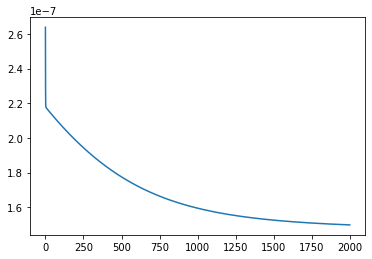

In [1]:
import sys
sys.path.append('..')
# reload local packages automatically
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)

# Import packages.
import cvxpy as cp
import numpy as np

import matplotlib.pyplot as plt

from opentn.transformations import create_kitaev_liouvillians, exp_operator_dt, factorize_psd, super2choi
d, N = 2, 4
dim = d**N
Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=1e-2)
tau = 4
superops_exp = []
for i, op in enumerate([Lvec, Lvec_odd, Lvec_even]):
    if i == 1:
        superops_exp.append(exp_operator_dt(op, tau/2, 'jax'))
    else:
        superops_exp.append(exp_operator_dt(op, tau, 'jax'))
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = superops_exp

X1 = factorize_psd(psd=super2choi(exp_Lvec_odd), tol=1e-12)
X2 = factorize_psd(psd=super2choi(exp_Lvec_even), tol=1e-12)

from opentn.optimization import gds, frobenius_norm, model_Ys, compute_loss
cost_n4, grads_n4, xi_n4 = gds(fn=compute_loss, x0=[X1, X2, X1], iter=int(2e3), loss_fn=frobenius_norm, model=model_Ys, rate=1.5e-9, exact = exp_Lvec, show_cost=False)
print(cost_n4[0])
print(cost_n4[-1])

plt.plot(cost_n4)

In [2]:
from opentn.transformations import super2choi, choi_composition, partial_transpose
from opentn.optimization import small2zero
from scipy import sparse

# rest of matrices optimized with GSD
X1_gds, X2_gds, X3_gds = xi_n4[-1]
Y2 = X2_gds@X2_gds.conj().T
Y3 = X3_gds@X3_gds.conj().T

tol = 1e-10
# rhs to which we want to approximate
rhs = np.asarray(super2choi(superop=exp_Lvec, dim=dim))
srhs = sparse.csr_matrix(small2zero(rhs, tol=tol)) # small2zero was deleted
srhs = srhs.astype(np.float64)

# change partial transpose to A
A = choi_composition(C1=Y2, C2=Y3, dim=dim) # small2zero was deleted
A_tb = partial_transpose(A, dims=[dim, dim], idx=1)
I = np.eye(dim)
A_tbxI = np.kron(A_tb, I)
sA_tbxI = sparse.csr_matrix(small2zero(A_tbxI, tol=tol))
sA_tbxI = sA_tbxI.astype(np.float64)
sA_tbxI

X_initial = small2zero(X1_gds@X1_gds.conj().T, tol=tol).astype(np.float64)

/Users/emiliano_gr/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/scipy/sparse/_data.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  self._deduped_data().astype(dtype, casting=casting, copy=copy),
/var/folders/_n/xw2mchz92t9_fcbxg7lwsdwh0000gn/T/ipykernel_15804/2257793326.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  X_initial = small2zero(X1_gds@X1_gds.conj().T, tol=tol).astype(np.float64)


In [12]:
X = cp.Variable((dim**2,dim**2), PSD=True)
lhs =  cp.partial_trace(sA_tbxI @ cp.kron(I, X), dims=[dim, dim, dim], axis=1)
cost = cp.norm(lhs - srhs, "fro")
prob = cp.Problem(cp.Minimize(cost))
X.value = X_initial

In [13]:
print(cp.installed_solvers())

['CLARABEL', 'COPT', 'ECOS', 'ECOS_BB', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


In [14]:
mosek_params = {'MSK_DPAR_INTPNT_CO_TOL_REL_GAP':1e-10, 'MSK_DPAR_INTPNT_CO_TOL_DFEAS':1e-10, 'MSK_DPAR_INTPNT_CO_TOL_MU_RED':1e-10, 'MSK_DPAR_INTPNT_CO_TOL_PFEAS':1e-10}
prob.solve(solver=cp.MOSEK, verbose=True, canon_backend=cp.SCIPY_CANON_BACKEND, mosek_params=mosek_params)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jul 27 12:17:33 AM: Your problem has 65536 variables, 0 constraints, and 0 parameters.
(CVXPY) Jul 27 12:17:33 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 27 12:17:33 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 27 12:17:33 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 27 12:17:33 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Jul 27 12:17:33 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

1.5679303929926725e-07

In [20]:
max_idx = 32
print(np.sort(np.linalg.svd(X.value, compute_uv=False))[::-1][:max_idx])
np.linalg.matrix_rank(X.value, tol=1e-8)

[1.59601247e+01 1.99251776e-02 1.99251753e-02 2.48857364e-05
 5.69463410e-08 4.94522997e-08 4.67828288e-08 4.28095430e-08
 4.09429693e-08 2.28724141e-08 1.82394528e-08 1.37084434e-08
 7.30374788e-09 7.27442924e-09 7.22211465e-09 7.17190953e-09
 7.16522009e-09 7.16300467e-09 7.16300467e-09 7.16300467e-09
 7.16300467e-09 7.16300467e-09 7.16300467e-09 7.16300467e-09
 7.16300467e-09 7.16300467e-09 7.16300467e-09 7.16215750e-09
 7.16124060e-09 7.15418102e-09 7.15126386e-09 7.15126385e-09]


12

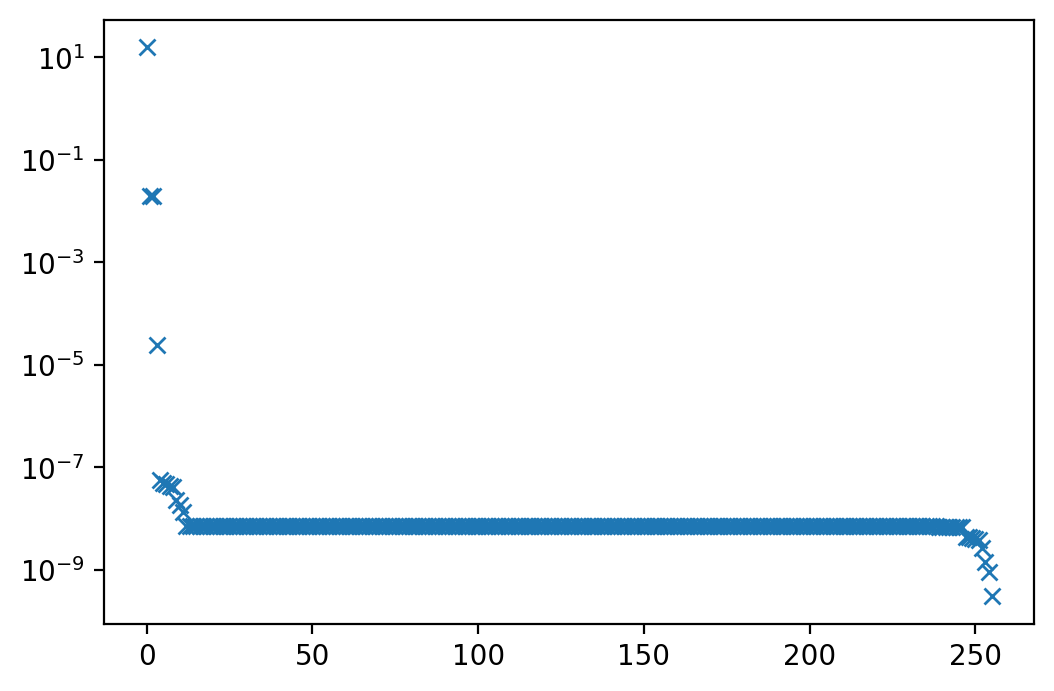

In [19]:
plt.figure(dpi=200)
plt.semilogy(np.linalg.svd(X.value, compute_uv=False), 'x')